## Create SparkSession

In [27]:
# import necessary libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplot

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, mean, to_date, year, month

# Create a SparkSession
spark = SparkSession.builder.appName("WeatherAnalysis").getOrCreate()

## Show databases from HIVE

In [2]:
spark.sql("show databases").show()

2024-12-07 14:24:02,714 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2024-12-07 14:24:02,717 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist


+---------+
|namespace|
+---------+
|  default|
|     mydb|
+---------+



## Use mydb database

In [3]:
spark.sql('use mydb')

2024-12-07 14:24:12,233 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


DataFrame[]

## Show mydb tables

In [4]:
spark.sql('show tables').show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|    mydb|             authors|      false|
|    mydb|                cars|      false|
|    mydb|weather_data_part...|      false|
+--------+--------------------+-----------+



## Show Columns

In [5]:
spark.sql('show columns in weather_data_partitioned_by_month').show()

+--------------------+
|            col_name|
+--------------------+
|                Date|
|                Time|
| Water_Content_m3_m3|
|Solar_Radiation_W_m2|
|             Rain_mm|
| Temperature_Celsius|
|          RH_percent|
|      Wind_Speed_m_s|
|      Gust_Speed_m_s|
|Wind_Direction_De...|
|   Dew_Point_Celsius|
|               month|
+--------------------+



## Describe Data

In [6]:
spark.sql('desc weather_data_partitioned_by_month').show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|                Date|     date|   null|
|                Time|   string|   null|
| Water_Content_m3_m3|   double|   null|
|Solar_Radiation_W_m2|   double|   null|
|             Rain_mm|   double|   null|
| Temperature_Celsius|   double|   null|
|          RH_percent|   double|   null|
|      Wind_Speed_m_s|   double|   null|
|      Gust_Speed_m_s|   double|   null|
|Wind_Direction_De...|   double|   null|
|   Dew_Point_Celsius|   double|   null|
|               month|   string|   null|
|# Partition Infor...|         |       |
|          # col_name|data_type|comment|
|               month|   string|   null|
+--------------------+---------+-------+



## Load Data into Dataframe

In [12]:
df = spark.sql("SELECT * FROM mydb.weather_data_partitioned_by_month")

## Check Outlier

In [42]:
def find_outliers_IQR(spark_df, column):
        # Calculate Q1 and Q3
        q1, q3 = spark_df.approxQuantile(column, [0.25, 0.75], 0.0)
        IQR = q3 - q1

        # Define outlier bounds
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR

        # Filter outliers
        outliers = spark_df.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound))
        return outliers

In [43]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType


# Identify numeric columns
numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

# Iterate over numeric columns and check for outliers
for column in numeric_columns:
    outliers = find_outliers_IQR(df, column)
    num_outliers = outliers.count()
    
    if num_outliers > 0:
        max_outlier = outliers.agg(F.max(column).alias('max_outlier')).collect()[0]['max_outlier']
        min_outlier = outliers.agg(F.min(column).alias('min_outlier')).collect()[0]['min_outlier']
        print(f"Column: {column}")
        print(f"  Number of outliers: {num_outliers}")
        print(f"  Max outlier value: {max_outlier}")
        print(f"  Min outlier value: {min_outlier}")
        print("-" * 40)
    else:
        print(f"Column: {column}")
        print("  No outliers found.")
        print("-" * 40)

Column: Water_Content_m3_m3
  Number of outliers: 4902
  Max outlier value: 0.3915
  Min outlier value: -99850510000.0
----------------------------------------


Column: Solar_Radiation_W_m2
  Number of outliers: 6468
  Max outlier value: 41269.0
  Min outlier value: 819.0
----------------------------------------


Column: Rain_mm
  Number of outliers: 3177
  Max outlier value: 6555.2
  Min outlier value: 0.2
----------------------------------------


Column: Temperature_Celsius
  Number of outliers: 612
  Max outlier value: 537.33
  Min outlier value: -888.88
----------------------------------------


Column: RH_percent
  Number of outliers: 437
  Max outlier value: 3361.5
  Min outlier value: 0.0
----------------------------------------


Column: Wind_Speed_m_s
  Number of outliers: 27027
  Max outlier value: 43.1
  Min outlier value: 1.0
----------------------------------------


Column: Gust_Speed_m_s
  Number of outliers: 3204
  Max outlier value: 48.4
  Min outlier value: -888.88
----------------------------------------


Column: Wind_Direction_Degree
  Number of outliers: 2881
  Max outlier value: -888.88
  Min outlier value: -888.88
----------------------------------------


Column: Dew_Point_Celsius
  Number of outliers: 7020
  Max outlier value: 537.96
  Min outlier value: -888.88
----------------------------------------


## Show the outlier as boxplot

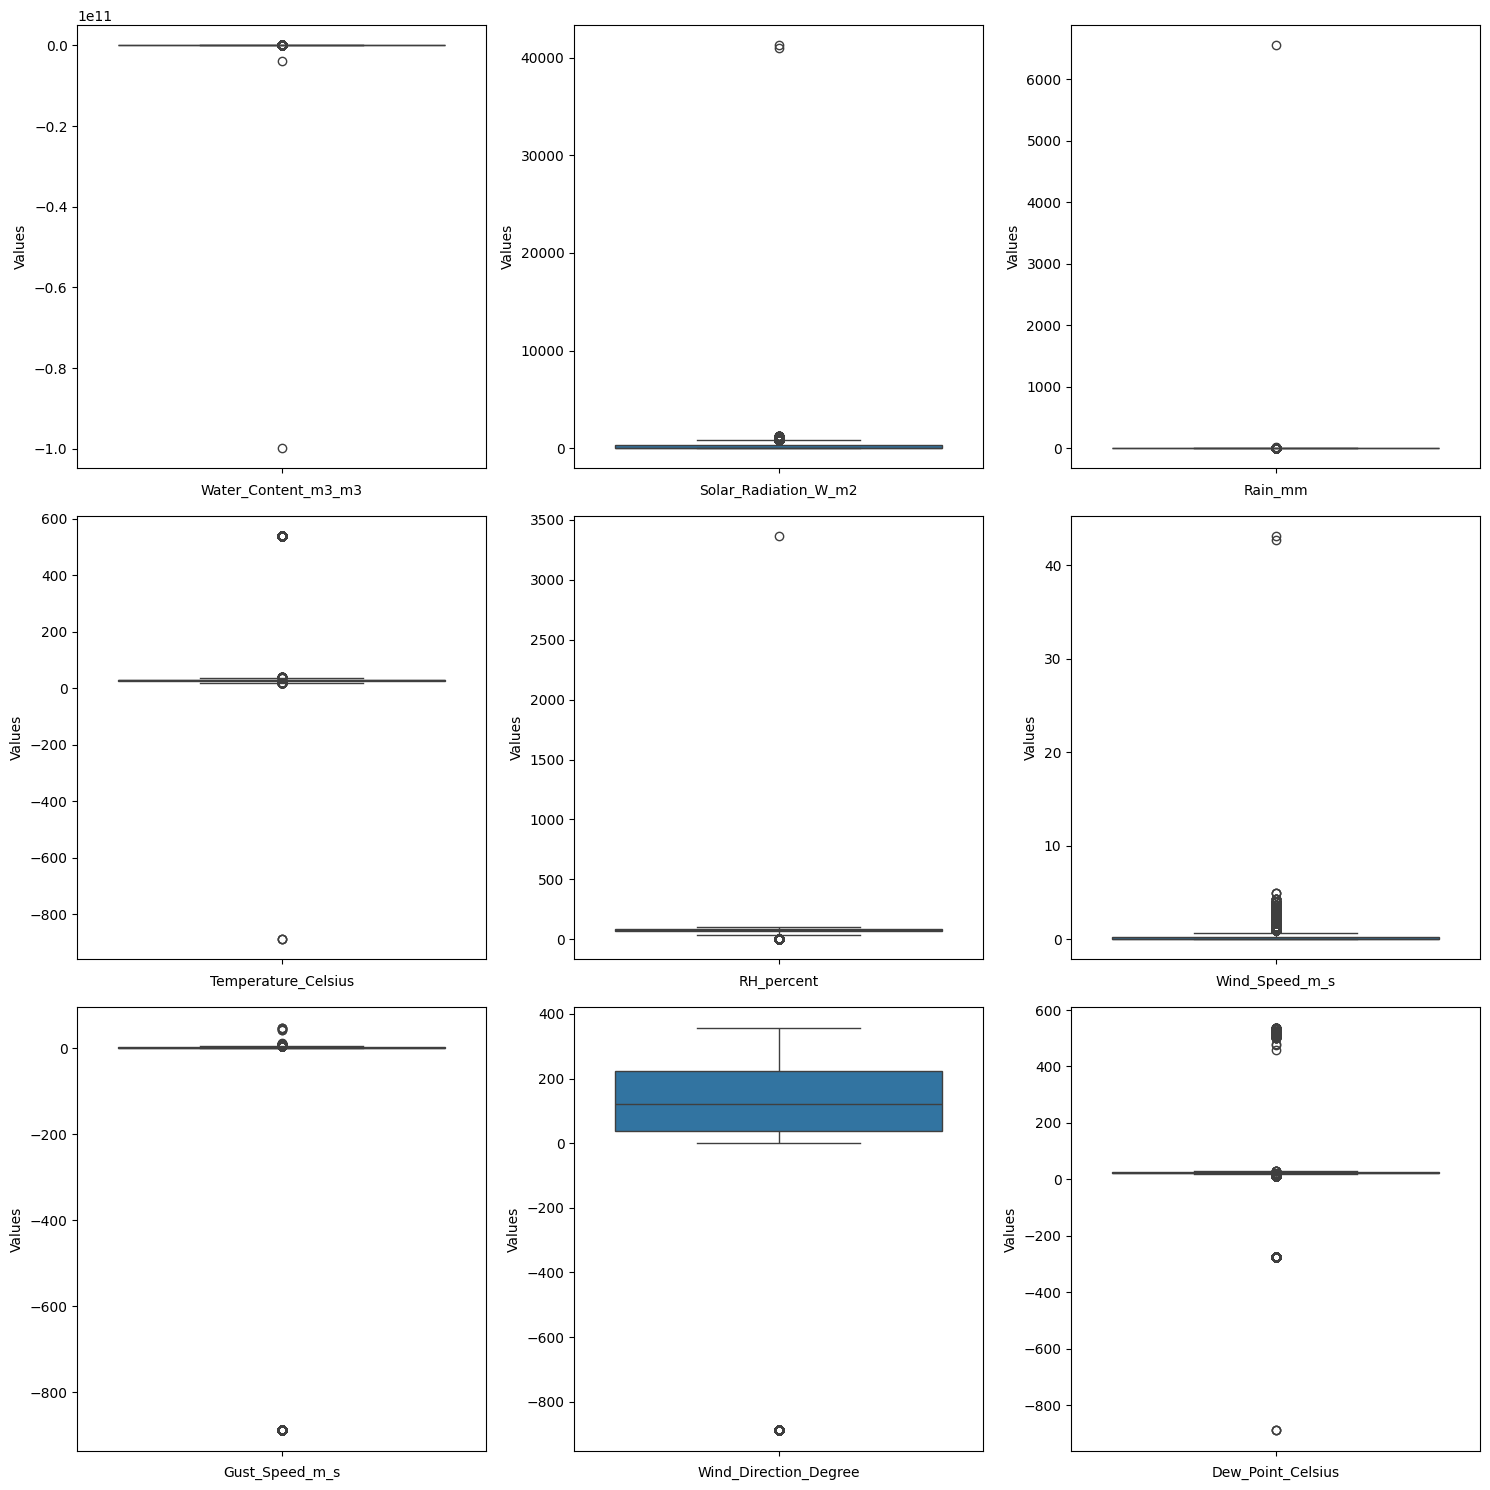

In [54]:
numeric_data = df.select(numeric_columns).toPandas()

ncols = 3 
nrows = int(np.ceil(len(numeric_columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=numeric_data[column], ax=axes[i])
    axes[i].set_ylabel("Values")
    axes[i].set_xlabel(column)

for i in range(len(numeric_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('before_remove_outlier.png')
plt.show()

## Remove Outlier

In [51]:
from scipy.stats import zscore

def remove_outliers_zscore(spark_df):
    # Convert PySpark DataFrame to Pandas DataFrame for Z-score calculation
    pandas_df = df.toPandas()
    
    # Columns to check for outliers
    numeric_columns = [
        'Water_Content_m3_m3', 
        'Solar_Radiation_W_m2', 
        'Rain_mm', 
        'Temperature_Celsius', 
        'RH_percent', 
        'Wind_Speed_m_s', 
        'Gust_Speed_m_s', 
        'Wind_Direction_Degree', 
        'Dew_Point_Celsius'
    ]
    
    # Calculate Z-scores for each column
    for col_name in numeric_columns:
        pandas_df[f'{col_name}_zscore'] = zscore(pandas_df[col_name])
    
    # Remove outliers (rows with Z-score outside [-3, 3])
    for col_name in numeric_columns:
        pandas_df = pandas_df[
            (pandas_df[f'{col_name}_zscore'] >= -3.0) & 
            (pandas_df[f'{col_name}_zscore'] <= 3.0)
        ]
    
    # Drop Z-score columns
    for col_name in numeric_columns:
        pandas_df = pandas_df.drop(columns=[f'{col_name}_zscore'])
    
    # Convert back to Spark DataFrame
    cleaned_spark_df = spark.createDataFrame(pandas_df)
    
    return cleaned_spark_df

# Apply the outlier removal
df_cleaned = remove_outliers_zscore(df)

## After Remove Outlier

2024-12-08 22:39:04,707 WARN scheduler.TaskSetManager: Stage 106 contains a task of very large size (4001 KiB). The maximum recommended task size is 1000 KiB.


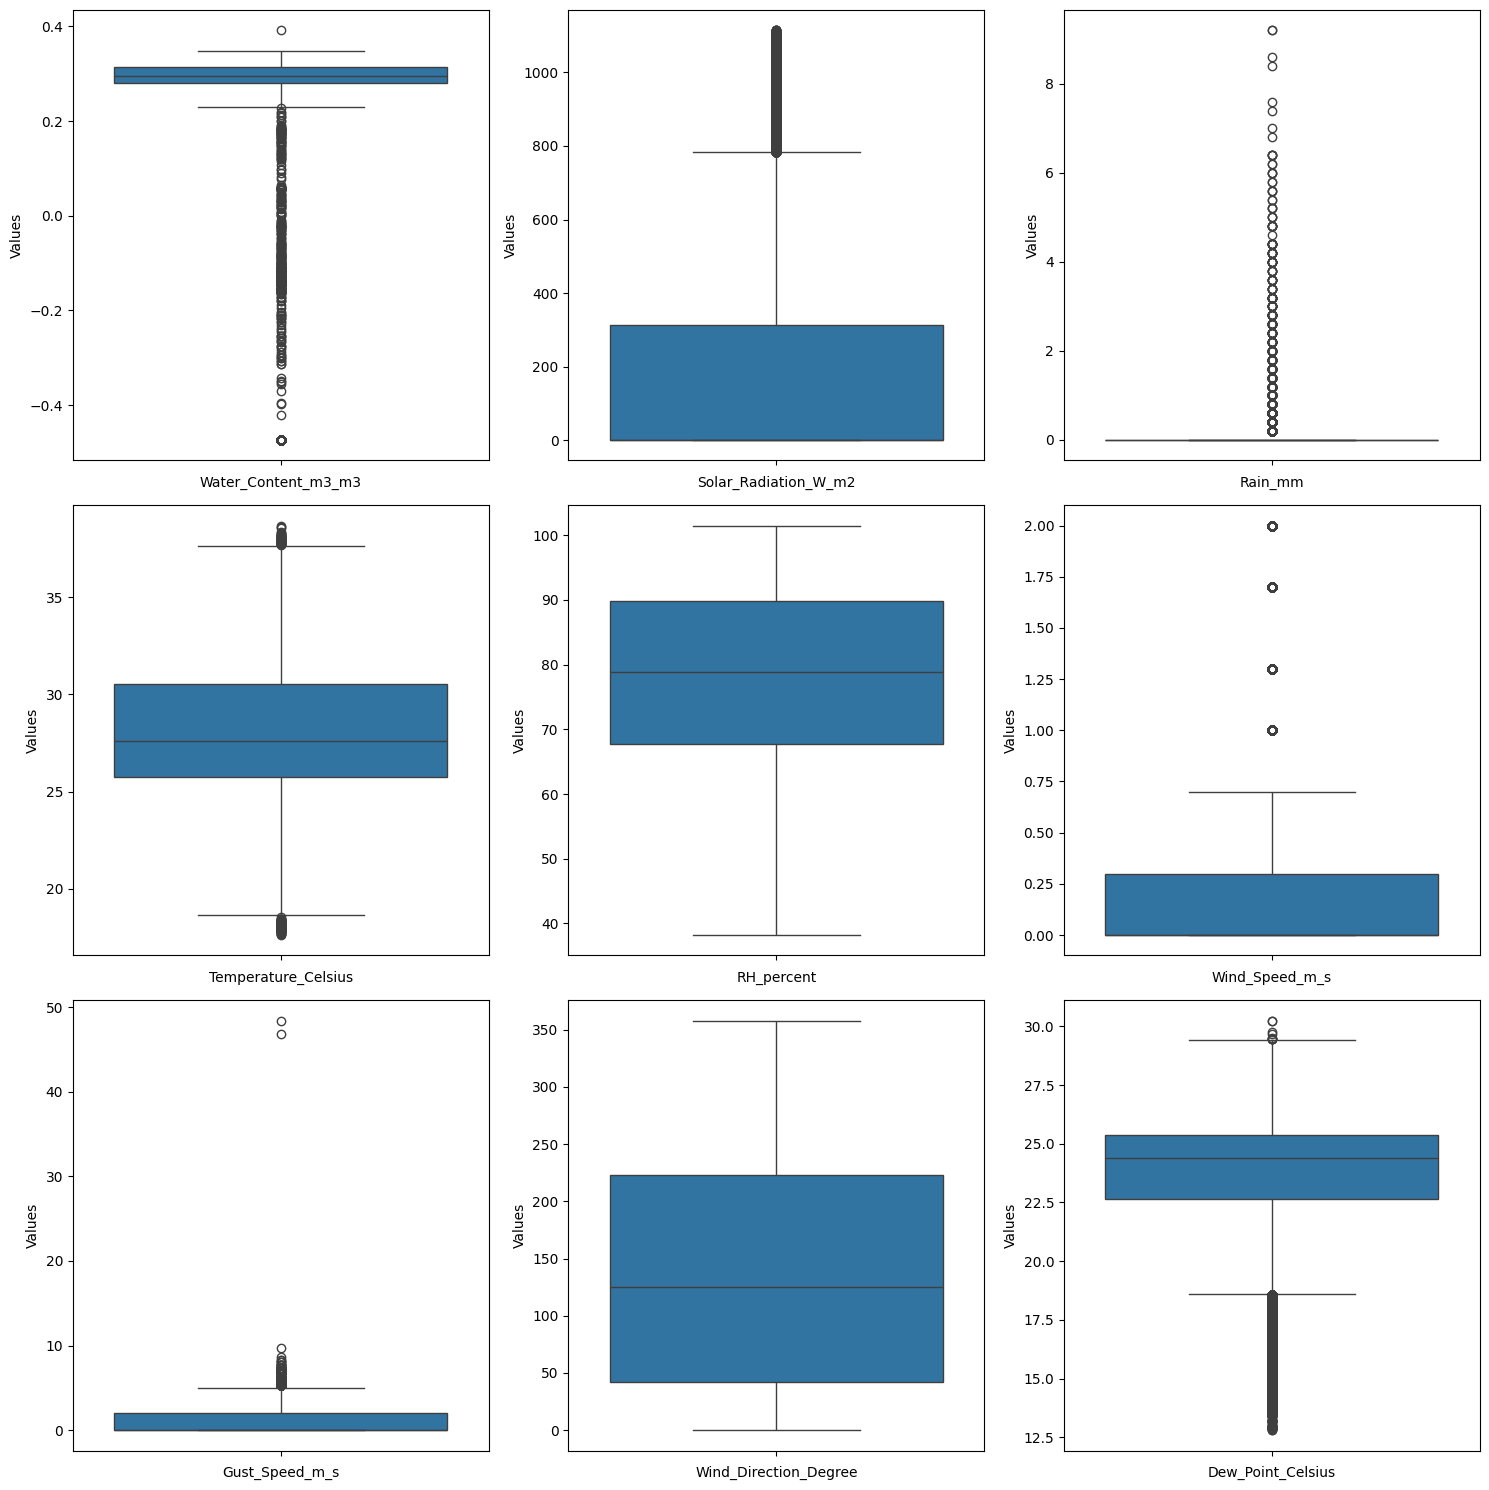

In [53]:
numeric_data = df_cleaned.select(numeric_columns).toPandas()

ncols = 3 
nrows = int(np.ceil(len(numeric_columns) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=numeric_data[column], ax=axes[i])
    axes[i].set_ylabel("Values")
    axes[i].set_xlabel(column)

for i in range(len(numeric_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('after_removed_outlier.png')
plt.show()

## Basic Statistical Summary

In [55]:
numeric_columns = [
    "Temperature_Celsius", 
    "Solar_Radiation_W_m2", 
    "Rain_mm", 
    "Wind_Speed_m_s"
]
summary_stats = df_cleaned.select([
    avg(col(c)).alias(f"Avg_{c}") for c in numeric_columns
] + [
    min(col("Temperature_Celsius")).alias("Min_Temperature"),
    max(col("Temperature_Celsius")).alias("Max_Temperature")
])

In [56]:
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


## Monthly Temperature Analysis

In [57]:
monthly_temp = df_cleaned.withColumn("full_date", to_date(col("Date"), "yyyy-MM-dd")) \
    .groupBy(year(col("full_date")).alias("year"), month(col("full_date")).alias("month")) \
    .agg(
        avg(col("Temperature_Celsius")).alias("Avg_Temperature"),
        min(col("Temperature_Celsius")).alias("Min_Temperature"),
        max(col("Temperature_Celsius")).alias("Max_Temperature")
    ).orderBy("year", "month")

monthly_temp_pandas = monthly_temp.toPandas()

2024-12-08 22:40:20,557 WARN scheduler.TaskSetManager: Stage 108 contains a task of very large size (4001 KiB). The maximum recommended task size is 1000 KiB.


## Visualization 1: Monthly Temperature Variation

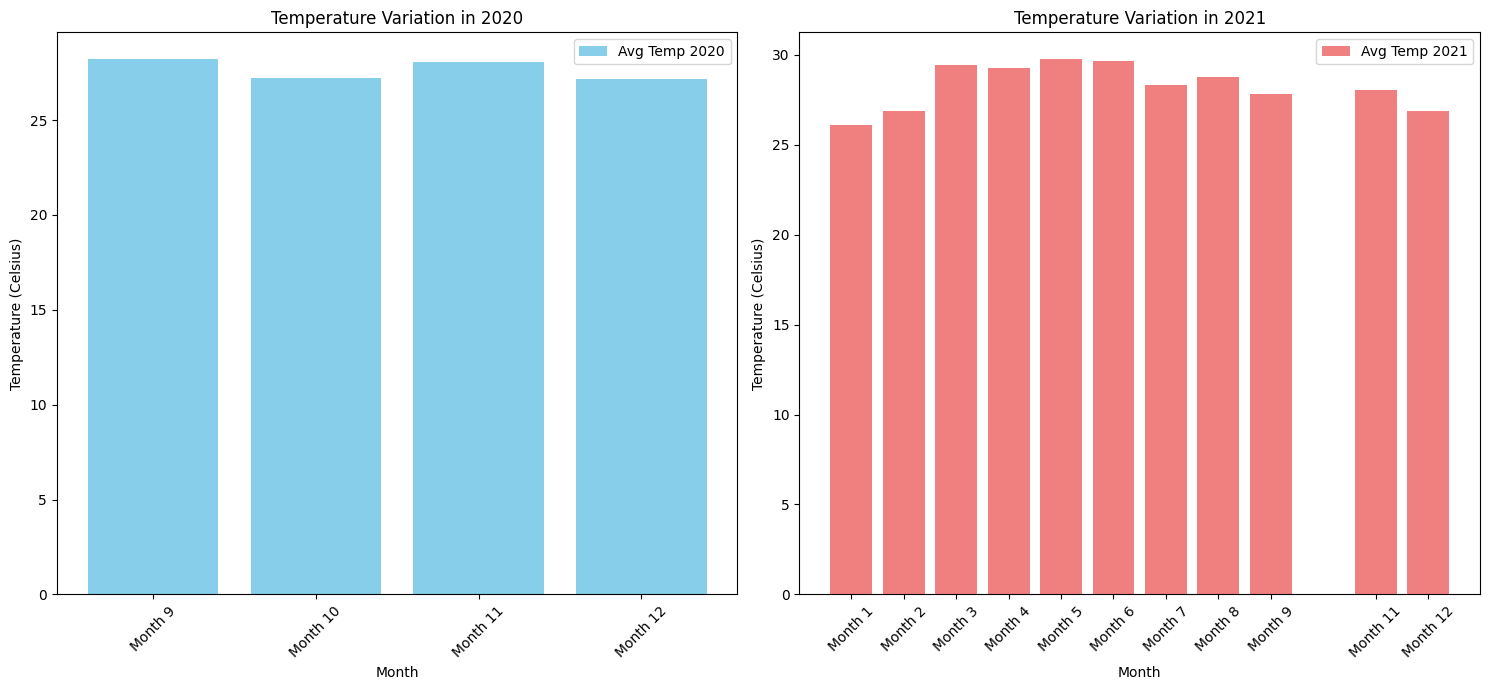

In [58]:
# Create bar charts for temperature variations
plt.figure(figsize=(15, 7))

# Plot for 2020
plt.subplot(1, 2, 1)
year_2020 = monthly_temp_pandas[monthly_temp_pandas['year'] == 2020]
plt.bar(year_2020['month'], year_2020['Avg_Temperature'], color='skyblue', label='Avg Temp 2020')
plt.title('Temperature Variation in 2020')
plt.xlabel('Month')
plt.ylabel('Temperature (Celsius)')
plt.xticks(year_2020['month'], labels=[f'Month {m}' for m in year_2020['month']], rotation=45)
plt.legend()

# Plot for 2021
plt.subplot(1, 2, 2)
year_2021 = monthly_temp_pandas[monthly_temp_pandas['year'] == 2021]
plt.bar(year_2021['month'], year_2021['Avg_Temperature'], color='lightcoral', label='Avg Temp 2021')
plt.title('Temperature Variation in 2021')
plt.xlabel('Month')
plt.ylabel('Temperature (Celsius)')
plt.xticks(year_2021['month'], labels=[f'Month {m}' for m in year_2021['month']], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## Correlation Analysis

In [59]:
correlation_columns = [
    'Temperature_Celsius', 'Solar_Radiation_W_m2', 
    'Rain_mm', 'Wind_Speed_m_s', 'RH_percent'
]

correlation_df = df_cleaned.select(correlation_columns)
correlation_matrix = correlation_df.toPandas().corr()

2024-12-08 22:40:59,210 WARN scheduler.TaskSetManager: Stage 113 contains a task of very large size (4001 KiB). The maximum recommended task size is 1000 KiB.


## Visualization 2: Correlation Heatmap

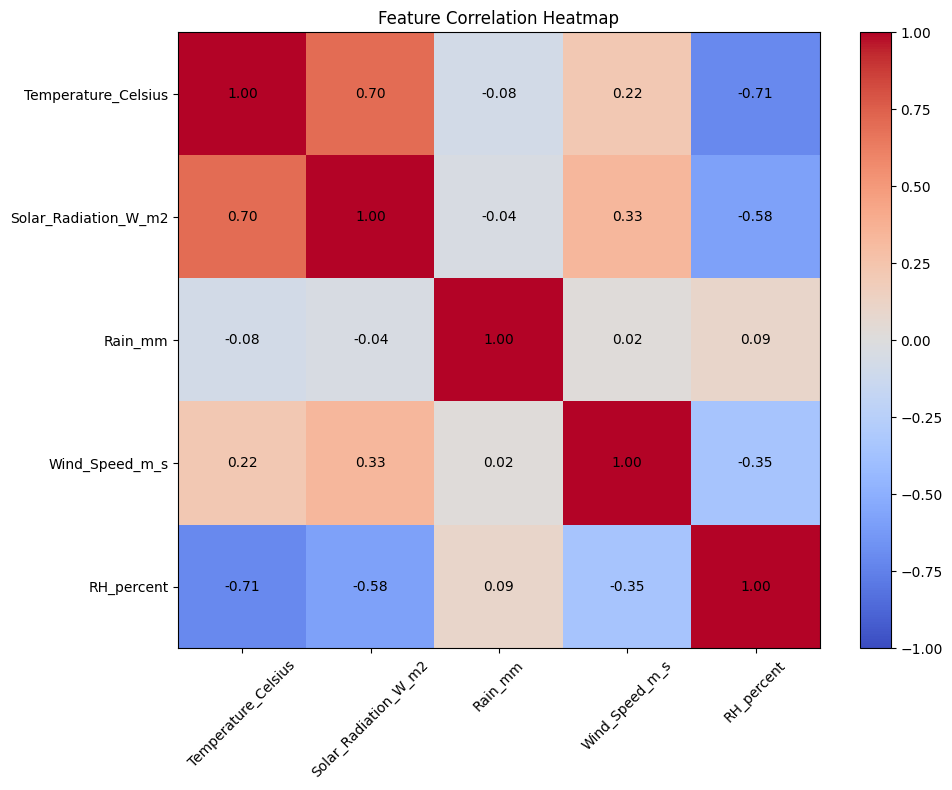

In [60]:
plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Feature Correlation Heatmap')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Annotate correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()
plt.savefig('correlation_heatmap.png')
plt.close()

## Seasonal Wind Speed Analysis

In [61]:
# Group by year and month after cleaning
wind_by_year_month = df_cleaned.withColumn("full_date", to_date(col("Date"), "yyyy-MM-dd")) \
    .groupBy(year(col("full_date")).alias("year"), month(col("full_date")).alias("month")) \
    .agg(
        avg(col("Wind_Speed_m_s")).alias("Avg_Wind_Speed"),
        avg(col("Gust_Speed_m_s")).alias("Avg_Gust_Speed")
    ).orderBy("year", "month")

wind_by_year_month_pandas = wind_by_year_month.toPandas()

2024-12-08 22:41:26,811 WARN scheduler.TaskSetManager: Stage 114 contains a task of very large size (4001 KiB). The maximum recommended task size is 1000 KiB.


## Visualization 3: Wind Speed Comparison

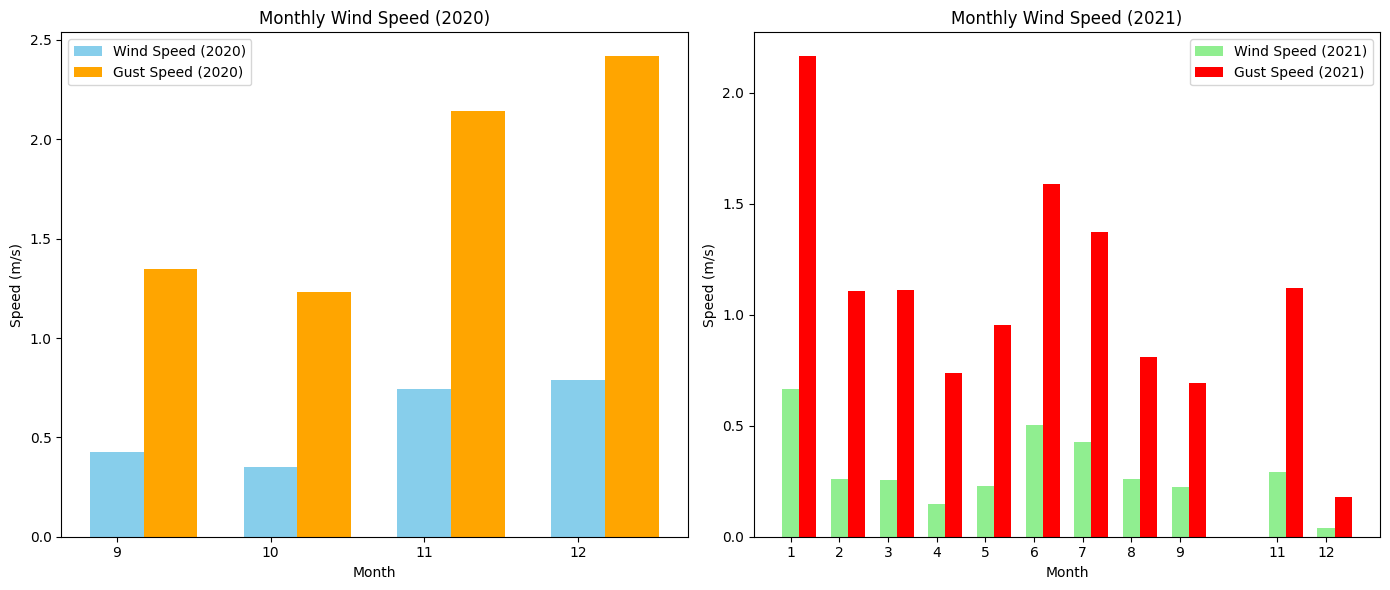

In [62]:
plt.figure(figsize=(14, 6))

# Plot for 2020
plt.subplot(1, 2, 1)
wind_2020 = wind_by_year_month_pandas[wind_by_year_month_pandas['year'] == 2020]
width = 0.35
plt.bar(wind_2020['month'], wind_2020['Avg_Wind_Speed'], width, label='Wind Speed (2020)', color='skyblue')
plt.bar(wind_2020['month'] + width, wind_2020['Avg_Gust_Speed'], width, label='Gust Speed (2020)', color='orange')
plt.title('Monthly Wind Speed (2020)')
plt.xlabel('Month')
plt.ylabel('Speed (m/s)')
plt.xticks(wind_2020['month'])
plt.legend()

# Plot for 2021
plt.subplot(1, 2, 2)
wind_2021 = wind_by_year_month_pandas[wind_by_year_month_pandas['year'] == 2021]
plt.bar(wind_2021['month'], wind_2021['Avg_Wind_Speed'], width, label='Wind Speed (2021)', color='lightgreen')
plt.bar(wind_2021['month'] + width, wind_2021['Avg_Gust_Speed'], width, label='Gust Speed (2021)', color='red')
plt.title('Monthly Wind Speed (2021)')
plt.xlabel('Month')
plt.ylabel('Speed (m/s)')
plt.xticks(wind_2021['month'])
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
from pyspark.sql.functions import when, col, lit

# Add a new column 'shift' based on the condition
solar_tem = df_cleaned.select('Solar_Radiation_W_m2', 'Temperature_Celsius').withColumn(
    'shift', 
    when(col('Solar_Radiation_W_m2') == lit(1), lit("Night")).otherwise(lit("Day"))
)
solar_tem_pd = solar_tem.toPandas()

2024-12-08 22:56:39,517 WARN scheduler.TaskSetManager: Stage 124 contains a task of very large size (4001 KiB). The maximum recommended task size is 1000 KiB.


## KDEPlot: Kernel Density Estimate Plot

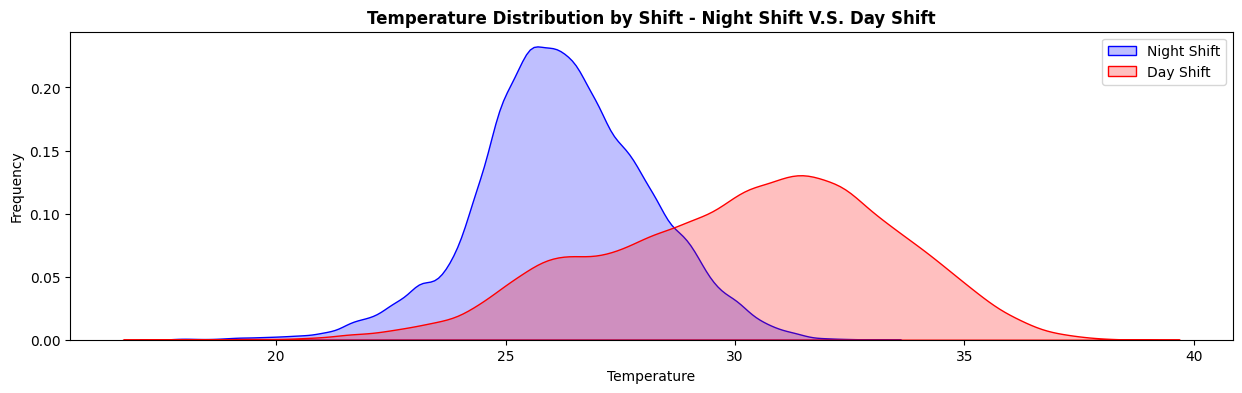

In [76]:
fig = plt.figure(figsize=(15, 4))
ax = sns.kdeplot(
    solar_tem_pd.loc[solar_tem_pd['shift'] == "Night", 'Temperature_Celsius'],
    color='b',
    fill=True,
    label='Night Shift'
)
ax = sns.kdeplot(
    solar_tem_pd.loc[solar_tem_pd['shift'] == "Day", 'Temperature_Celsius'],
    color='r',
    fill=True,
    label='Day Shift'
)
ax.set(xlabel='Temperature', ylabel='Frequency')
plt.legend()
plt.title('Temperature Distribution by Shift - Night Shift V.S. Day Shift', fontweight='bold')
plt.show()

In [79]:
#let's try with temperature values only first 
#select only date and temperature 

tem = df_cleaned.select('Date', 'Temperature_Celsius').toPandas()
tem.tail()

2024-12-09 22:11:41,538 WARN scheduler.TaskSetManager: Stage 125 contains a task of very large size (4001 KiB). The maximum recommended task size is 1000 KiB.


,Date,Temperature_Celsius
154615,2022-01-04,23.14
154616,2022-01-05,25.99
154617,2022-01-05,28.62
154618,2022-01-05,31.23
154619,2022-01-07,27.09


In [80]:
#check data points
tem.shape

(154620, 2)

In [81]:
#let's sum and mean on daily temperature 
#tem = tem.append(tem.agg(['mean']).rename({'mean':'avg_daily_temperature'}))
  
tem = tem.groupby(['Date'])['Temperature_Celsius'].mean()
tem = pd.DataFrame(tem)
tem.head()

,Temperature_Celsius
Date,
2020-09-01,27.922465
2020-09-02,27.288849
2020-09-03,28.490451
2020-09-04,29.702847
2020-09-05,30.362083


## Create a function for line plot

In [82]:
def line_plot(x, y, title):
    plt.figure(figsize=(25,6))
    sns.lineplot(x=x, y=y)
    plt.title(title, fontweight='bold', fontsize=15)
    plt.show()

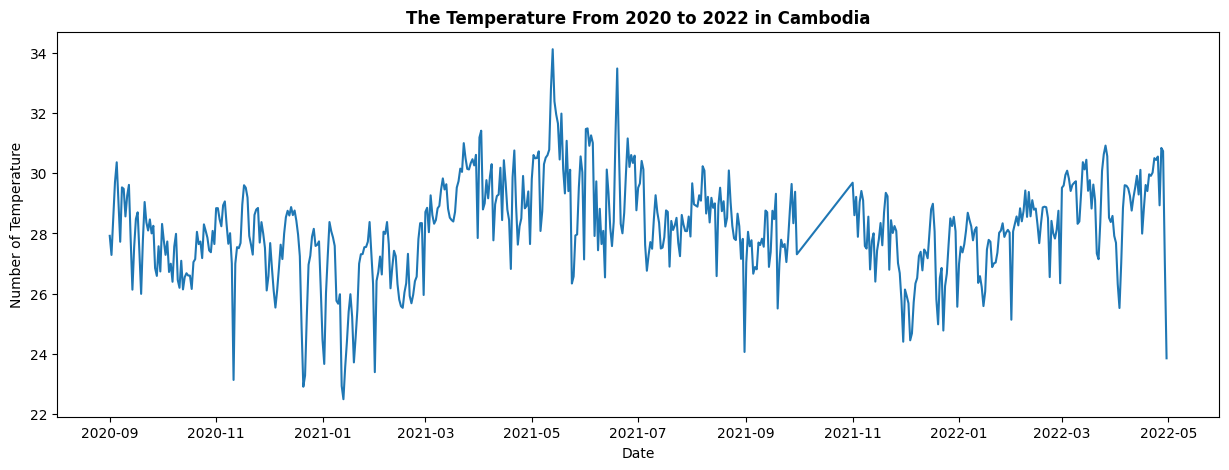

In [84]:
## plot line graph
plt.figure(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Number of Temperature')
plt.title('The Temperature From 2020 to 2022 in Cambodia', fontweight='bold')
plt.plot(tem)
plt.show()

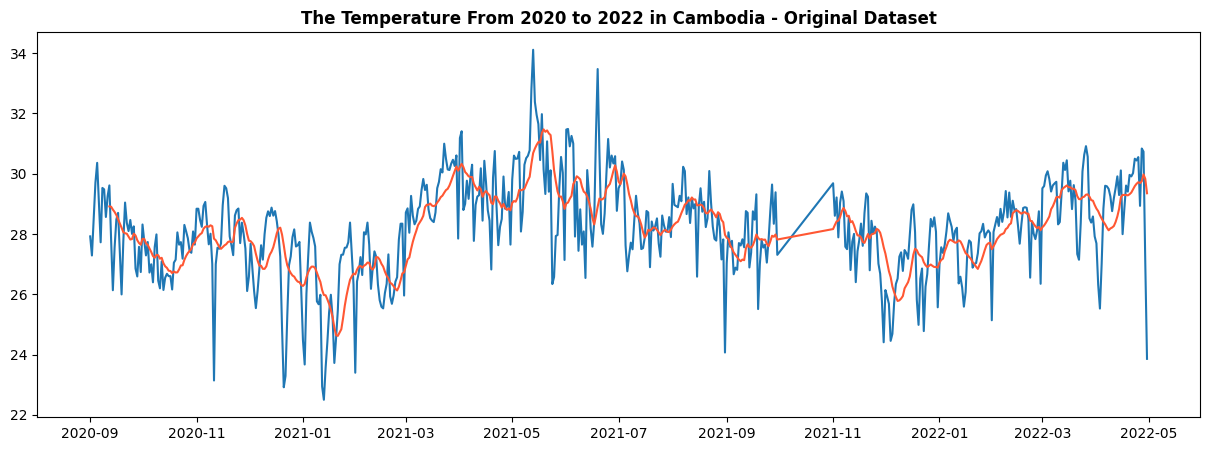

In [85]:
plt.figure(figsize=(15,5))
#check moving average in original dataset 
MA = tem.rolling(window=12).mean()
MA_STD = tem.rolling(window=12).std()
plt.title('The Temperature From 2020 to 2022 in Cambodia - Original Dataset', fontweight='bold')
plt.plot(tem)
plt.plot(MA, color='#FF5733')
plt.show()

In [88]:
#check the data between 2021-02 to 2021-04
start_date = pd.to_datetime('2021-01-30')
end_date = pd.to_datetime('2021-04-01')

# Ensure the index is datetime
tem.index = pd.to_datetime(tem.index)

# Filter rows
t = tem[(tem.index >= start_date) & (tem.index <= end_date)]
t = t.sort_index(ascending=True)

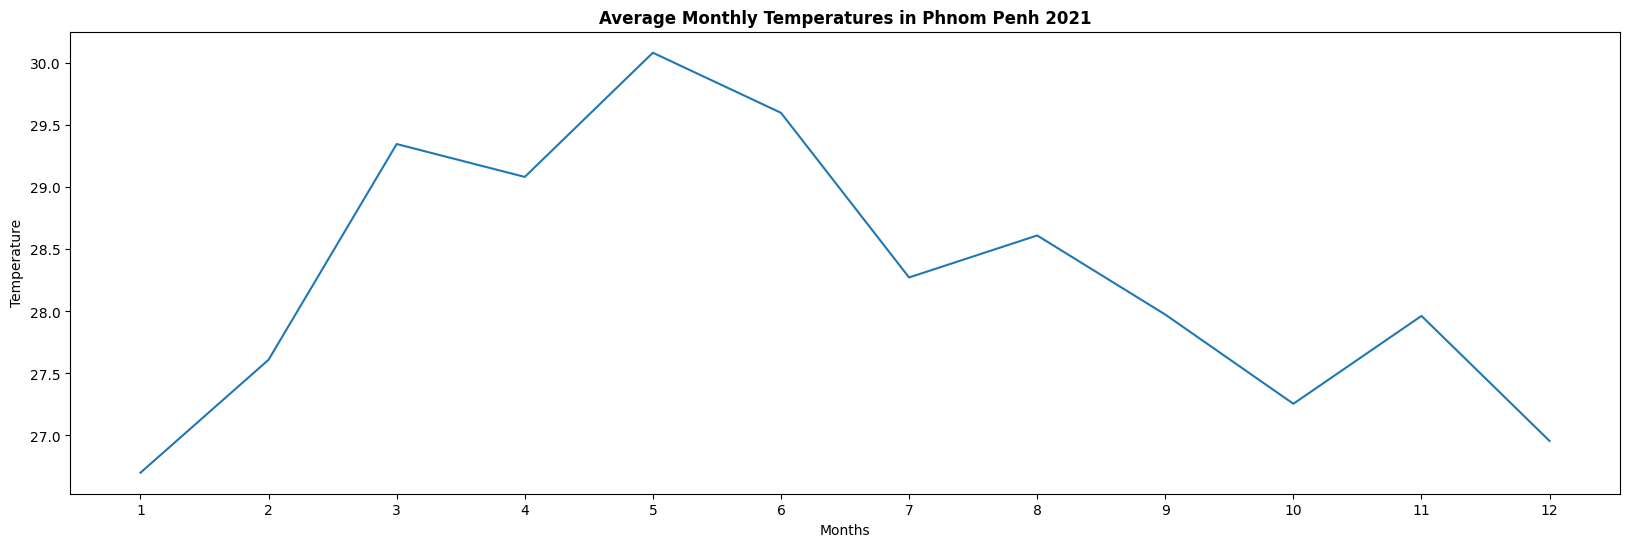

In [90]:
tem['month'] = tem.index.month
tem['year'] = tem.index.year
pivot = pd.pivot_table(tem, values='Temperature_Celsius', index='month', columns='year', aggfunc='mean')

monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Average Monthly Temperatures in Phnom Penh 2021', fontweight='bold')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

## Check the pivot 

In [91]:
pivot

year,2020,2021,2022
month,,,
1,NaN,25.950887,27.448658
2,NaN,26.815582,28.405093
3,NaN,29.355927,29.341610
4,NaN,29.207070,28.960433
5,NaN,30.084677,NaN
6,NaN,29.600351,NaN
7,NaN,28.273429,NaN
8,NaN,28.611890,NaN
9,28.161370,27.787504,NaN


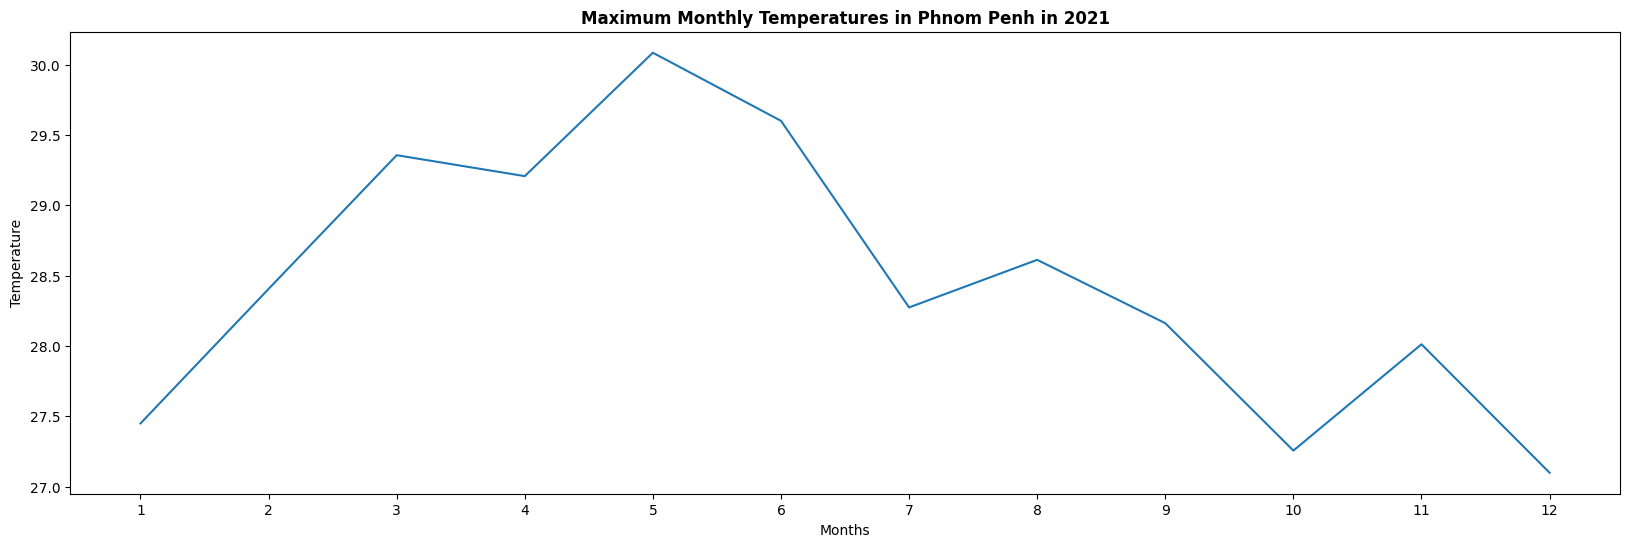

In [93]:
max_tem_monthly = pivot.groupby("month").max()

max_monthly_seasonality = max_tem_monthly.max(axis=1)
max_monthly_seasonality.plot(figsize=(20,6))
plt.title('Maximum Monthly Temperatures in Phnom Penh in 2021', fontweight='bold')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

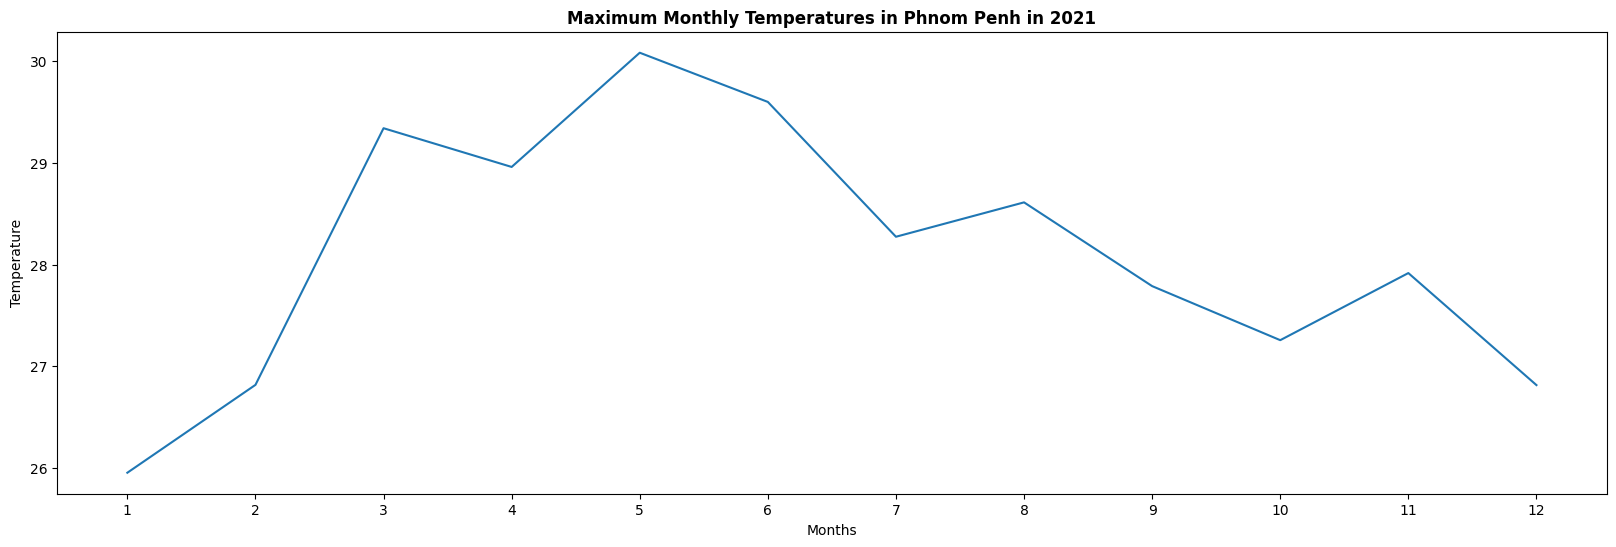

In [92]:
min_tem_monthly = pivot.groupby("month").min()

min_tem_monthly = min_tem_monthly.min(axis=1)
min_tem_monthly.plot(figsize=(20,6))
plt.title('Maximum Monthly Temperatures in Phnom Penh in 2021', fontweight='bold')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

## Select all the case in one plot

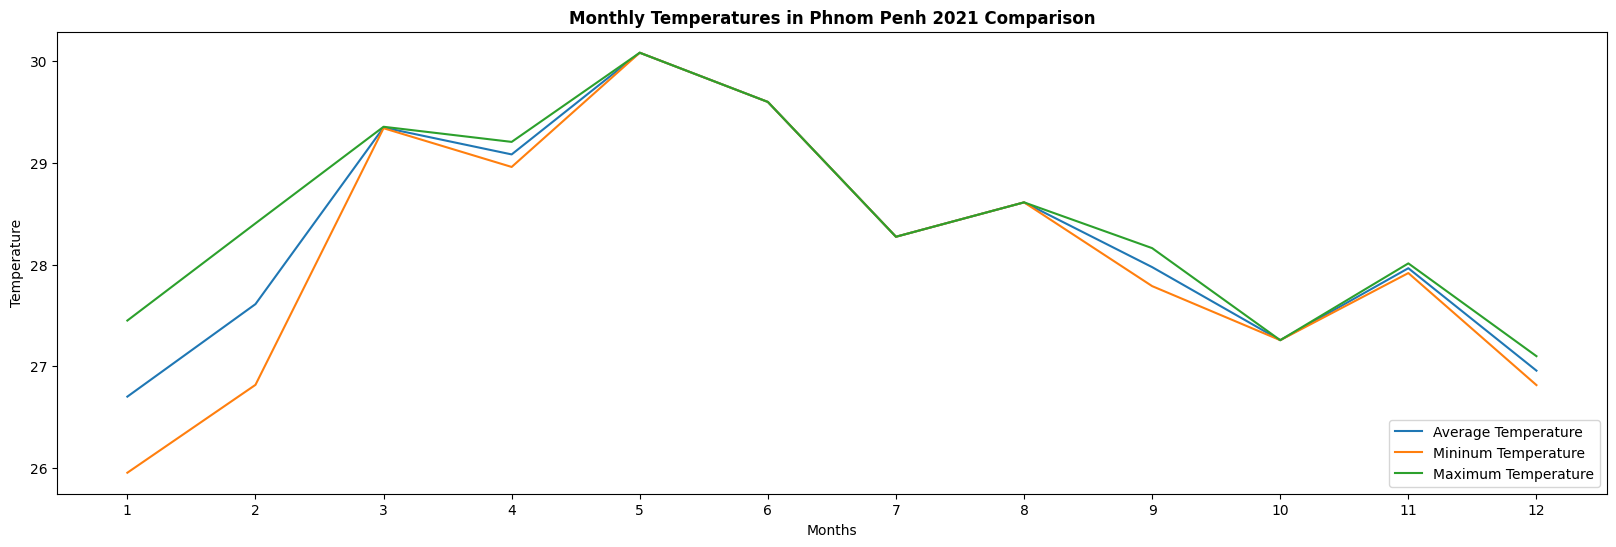

In [94]:
#average 
monthly_seasonality.plot(figsize=(20,6), legend="Average Temperature")
#min
min_tem_monthly.plot(figsize=(20,6), legend="Mininum Temperature")
#max
max_monthly_seasonality.plot(figsize=(20,6), legend="Maximum Temperature")

plt.title('Monthly Temperatures in Phnom Penh 2021 Comparison', fontweight='bold')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.legend(["Average Temperature", "Mininum Temperature", "Maximum Temperature"], loc ="lower right")
plt.xticks([x for x in range(1,13)])
plt.show()

In [106]:
#check the tem
tem

,Temperature_Celsius,month,year
Date,,,
2020-09-01,27.922465,9.0,2020.0
2020-09-02,27.288849,9.0,2020.0
2020-09-03,28.490451,9.0,2020.0
2020-09-04,29.702847,9.0,2020.0
2020-09-05,30.362083,9.0,2020.0
...,...,...,...
2022-04-26,28.934826,4.0,2022.0
2022-04-27,30.837847,4.0,2022.0
2022-04-28,30.733924,4.0,2022.0


In [107]:
#drop the month and year out 
tem.drop(['month', 'year'], axis=1, inplace=True)

In [108]:
#Determine rolling statistics
rolmean = tem.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = tem.rolling(window=12).std()
print(rolmean,rolstd)

            Temperature_Celsius
Date                           
2020-09-01                  NaN
2020-09-02                  NaN
2020-09-03                  NaN
2020-09-04                  NaN
2020-09-05                  NaN
...                         ...
2022-04-26            29.690573
2022-04-27            29.751157
2022-04-28            29.979308
2022-04-29            29.832399
2022-04-30            29.353212

[607 rows x 1 columns]             Temperature_Celsius
Date                           
2020-09-01                  NaN
2020-09-02                  NaN
2020-09-03                  NaN
2020-09-04                  NaN
2020-09-05                  NaN
...                         ...
2022-04-26             0.776145
2022-04-27             0.837853
2022-04-28             0.673052
2022-04-29             1.038233
2022-04-30             2.016341

[607 rows x 1 columns]


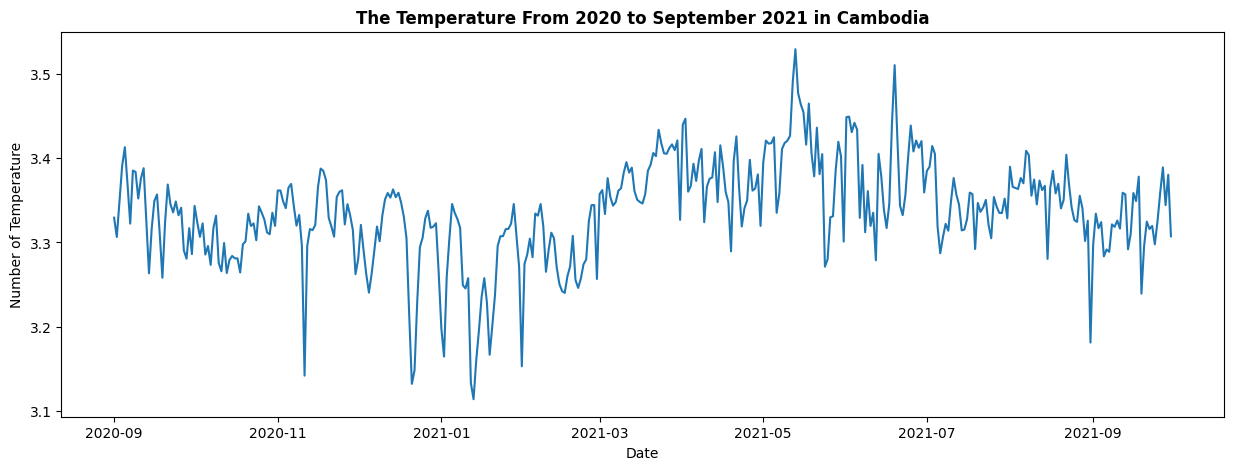

In [117]:
#Estimating trend
tem_logscale = np.log(tem)

# Filter data to include only up to September 2021
end_date = '2021-09-30'
filtered_data = tem_logscale[:end_date]  # Assuming 'tem_logscale' has a DateTime index

# Plot the filtered data
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Number of Temperature')
plt.title('The Temperature From 2020 to September 2021 in Cambodia', fontweight='bold')
plt.plot(filtered_data)
plt.show()

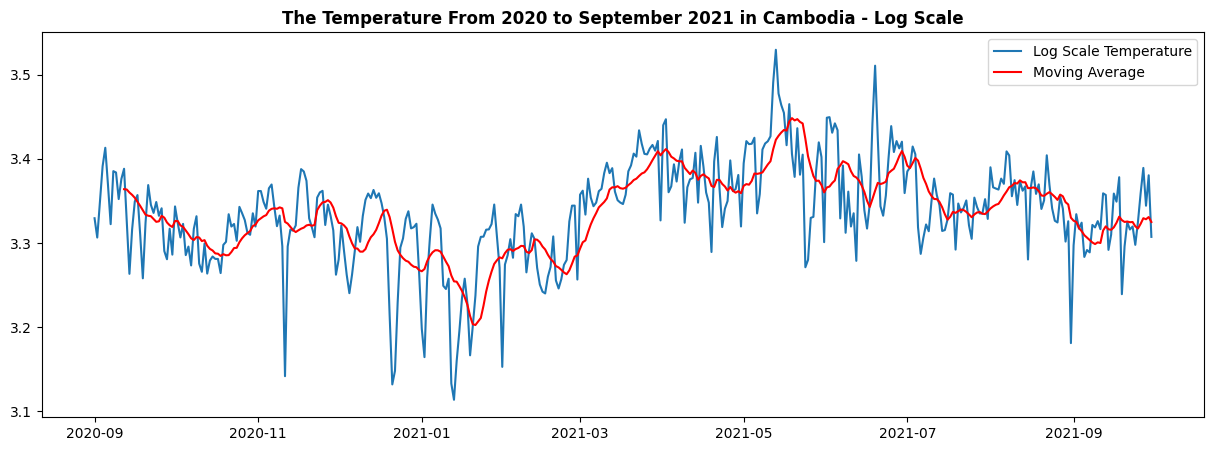

In [119]:
# Filter data to include only up to September 2021
end_date = '2021-09-30'
filtered_tem_logscale = tem_logscale[:end_date]  # Assuming tem_logscale has a DateTime index

# Calculate moving average and moving standard deviation for filtered data
movingAverage = filtered_tem_logscale.rolling(window=12).mean()
movingSTD = filtered_tem_logscale.rolling(window=12).std()

# Plot the transformed data and moving statistics
plt.figure(figsize=(15, 5))
plt.title('The Temperature From 2020 to September 2021 in Cambodia - Log Scale', fontweight='bold')
plt.plot(filtered_tem_logscale, label='Log Scale Temperature')
plt.plot(movingAverage, color='red', label='Moving Average')
plt.legend()
plt.show()

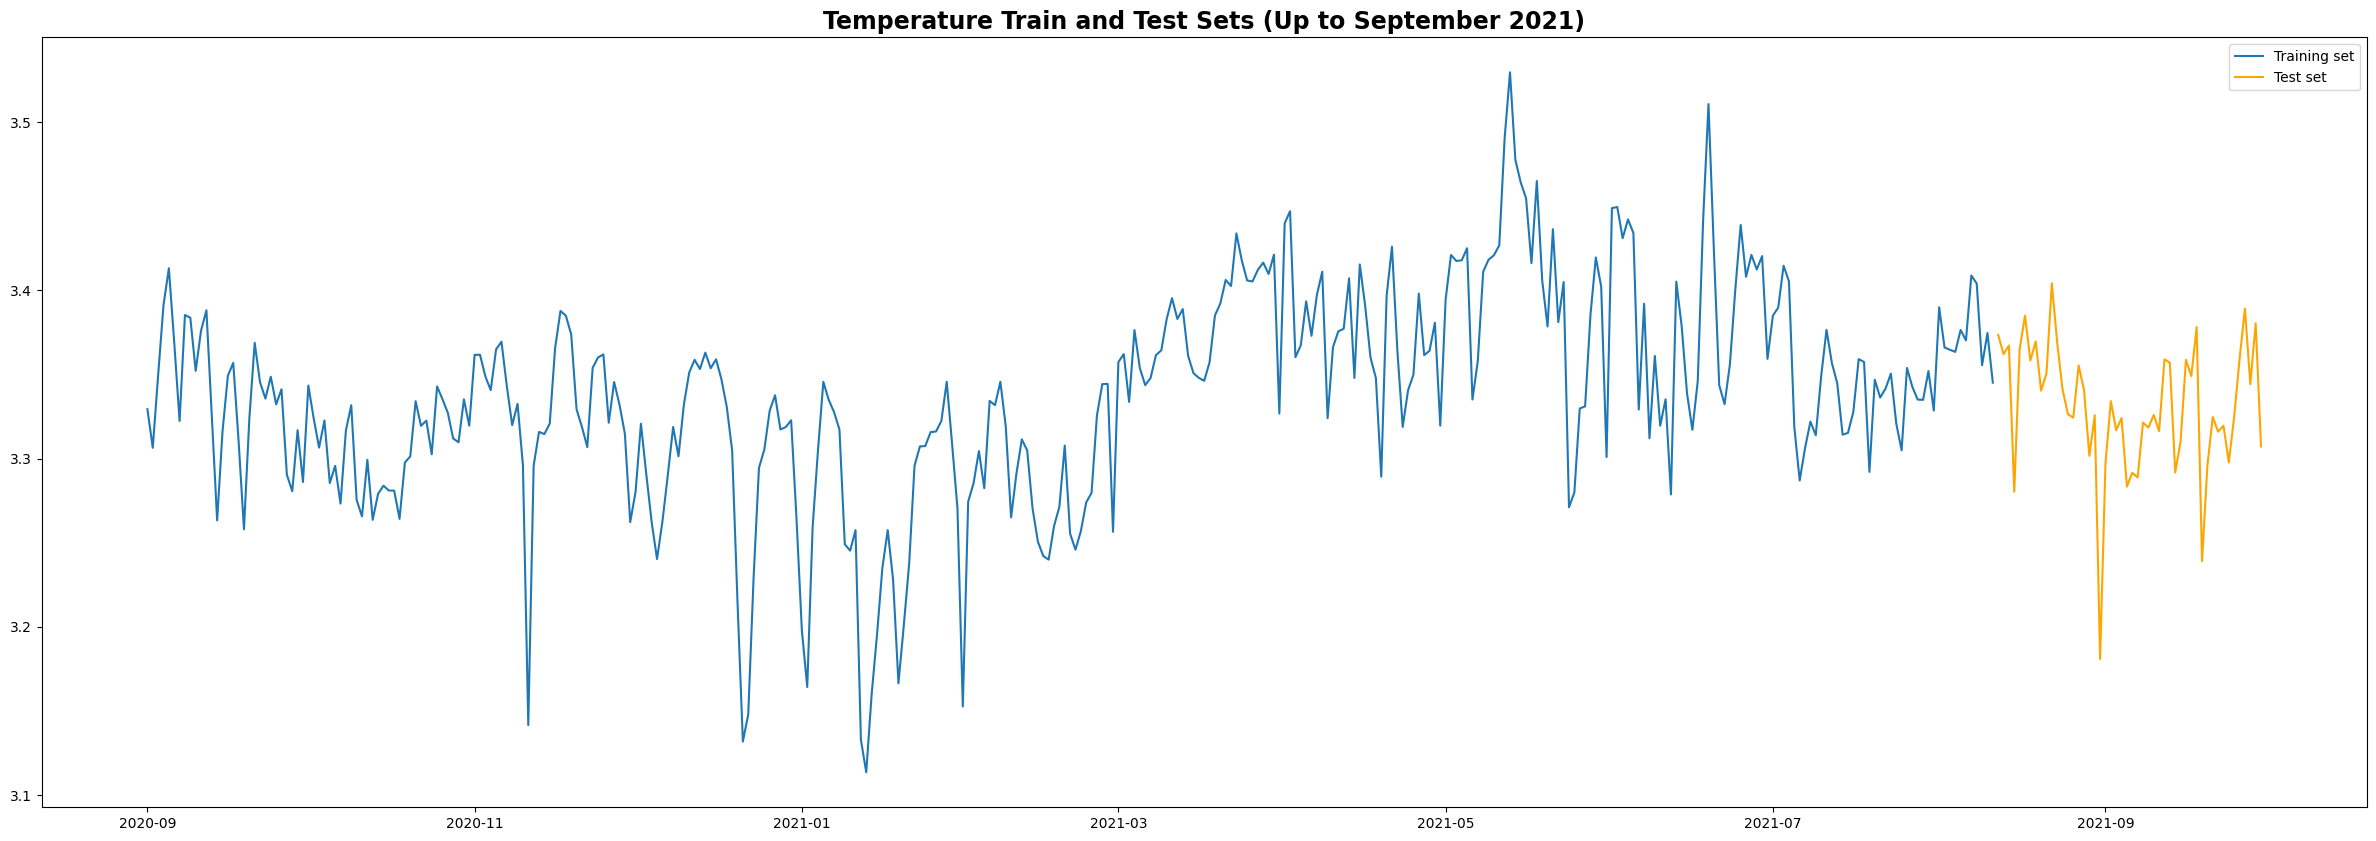

In [124]:
# Filter data to include only up to September 2021
end_date = '2021-09-30'
filtered_tem_logscale = tem_logscale[:end_date]  # Assuming tem_logscale has a DateTime index

# Data split into train and test sets
test_size = 50
tem_train = filtered_tem_logscale[:-test_size]
tem_test = filtered_tem_logscale[-test_size:]

# Plot the training and test sets
plt.figure(figsize=(30, 10))
plt.title('Temperature Train and Test Sets (Up to September 2021)', fontweight='bold', size=17)
plt.plot(tem_train, label='Training set')
plt.plot(tem_test, label='Test set', color='orange')
plt.legend()
plt.show()

## Save Dataframe in HDF5 Format for later use in another Jupyter Notebook File

In [127]:
tem_train.to_pickle('tem_train.pkl')
tem_test.to_pickle('tem_test.pkl')
filtered_tem_logscale.to_pickle('filtered_tem_logscale.pkl')